# using collocation module to start fitting waveforms

# imports

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.show()
plt.close()
matplotlib.rcParams.update({"font.size": 16})
default_cycle_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
print(default_cycle_colors)

from cycler import cycler
import numpy as np

import glob
import os

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

<Figure size 432x288 with 0 Axes>

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [2]:
import phenom

In [3]:
# custom module
import collocation as col

In [4]:
import sympy
# sympy.init_printing()
x_sym, a_sym, om_rd = sympy.symbols('x_sym a_sym om_rd')

In [5]:
def rd_ansatz_log(t, a, b):
    return np.log(a) - t*b

def connect_rd(t0, y0, fdamp):
    """
    y0 == y(t0)
    this is just fixing the constant offset between the phenom model from peak amplitude
    to about t0=30M.
    We assume the slope is given by the approximately known damping frequency
    We assume exponential decay so it's linear in log-space
    """
    b = fdamp*2*np.pi
    log_a = np.log(y0) + b * t0
    return np.exp(log_a), b

# load data

In [6]:
data = np.load("test_wf_data.npz", allow_pickle=True)

In [7]:
list(data.keys())

['wf_data', 'meta_data']

In [8]:
data['wf_data'].shape

(6, 5000, 4)

In [9]:
data['meta_data'][0]

{'nrfile': '/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5',
 'm1': 0.5,
 'm2': 0.5,
 'q': 1.0,
 'eta': 0.25,
 'fin_spin': 0.6864170524001022,
 'fring': 0.08808687827285246,
 'fdamp': 0.013595523411814124,
 'meco_frequency': -0.15396662670493216,
 'hybrid_meco_frequency': -0.15396662670493216,
 't_meco': -12.000190540863667}

In [10]:
data['meta_data'][-1]

{'nrfile': '/Users/sebastian.khan/personal/data/q18a0a0c025_144-22-hybrid.h5',
 'm1': 0.9473684210526315,
 'm2': 0.05263157894736842,
 'q': 18.0,
 'eta': 0.04986149584487535,
 'fin_spin': 0.16287147194320914,
 'fring': 0.0633342177068049,
 'fdamp': 0.014139929664054475,
 'meco_frequency': -0.13935066770814478,
 'hybrid_meco_frequency': -0.13935066770814478,
 't_meco': -28.470322406082317}

In [11]:
q_to_idx_mapper = {int(md['q']):i for i, md in enumerate(data['meta_data'])}

In [12]:
col_mapper = {'time':0, 'amp':1, 'phase':2, 'freq':3}

# example

## config fit data

In [13]:
# choose a mass-ratio and get index of data
q_to_idx_mapper[18]

5

In [14]:
q_to_idx_mapper.keys()

dict_keys([1, 2, 4, 5, 10, 18])

In [15]:
q = 1
assert q in q_to_idx_mapper.keys(), f'mass-ratio not available, pick from {list(q_to_idx_mapper.keys())}'

# target_data = 'amp'
target_data = 'freq'

idx = q_to_idx_mapper[q]

meta_data = data['meta_data'][idx]
wf_data = data['wf_data'][idx]

x = wf_data[:, col_mapper['time']]
y = wf_data[:, col_mapper[target_data]]

iy = IUS(x, y) # interpolate so we can estimate derivatives

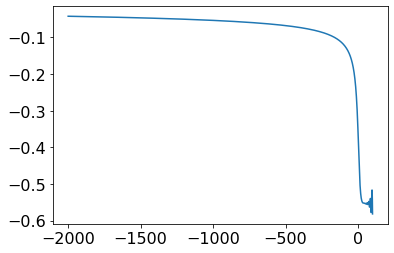

In [16]:
plt.plot(x, y)

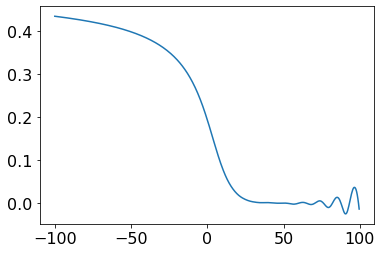

In [17]:
mask = (x > -100) & (x < 100)
plt.plot(x[mask], y[mask]-(-meta_data['fring']*2*np.pi))

## example fit data

In [18]:
# specify ansatz
# ansatz = 1 + x_sym + sympy.asinh(a_sym * x_sym) + sympy.asinh(a_sym * x_sym)**2 + sympy.asinh(a_sym * x_sym)**3
# ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(5)])
# ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(6)])



# merger/ringdown frequency
# eq. 28 & 29 (arXiv:2012.11923)
om_bar = np.sum([sympy.tanh(a_sym * (x_sym))**power for power in range(5)])
ansatz = om_rd * (1 - om_bar)
ansatz = sympy.expand(ansatz)

# ansatz = np.sum([sympy.tanh(a_sym * x_sym)**power for power in range(4)])
# ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(5)])


In [19]:
ansatz

-om_rd*tanh(a_sym*x_sym)**4 - om_rd*tanh(a_sym*x_sym)**3 - om_rd*tanh(a_sym*x_sym)**2 - om_rd*tanh(a_sym*x_sym)

In [20]:
len(ansatz.args)

4

In [21]:
ansatz.as_coefficients_dict()

defaultdict(int,
            {om_rd*tanh(a_sym*x_sym)**2: -1,
             om_rd*tanh(a_sym*x_sym)**3: -1,
             om_rd*tanh(a_sym*x_sym)**4: -1,
             om_rd*tanh(a_sym*x_sym): -1})

In [22]:
collocation_points = {
    # '0th':[-100, -12, 10],
    # '1st':[-100, 10],
    '0th':[10, 20, 30],
    '1st':[10],
    # '2nd':[20],
    # '3rd':[X[0]],
}

rhs = {
    '0th':np.array(list(map(iy, collocation_points['0th']))),
    '1st':np.array(list(map(iy.derivative(), collocation_points['1st']))),
    # '2nd':np.array(list(map(iy.derivative(2), collocation_points['2nd']))),
    # '3rd':np.array(list(map(iy.derivative(3), collocation_points['3rd']))),
}

sub_dict = {
    'a_sym':meta_data['fdamp']*2*np.pi,
    'om_rd':-meta_data['fring']*2*np.pi,
}

In [23]:
collocation_points

{'0th': [10, 20, 30], '1st': [10]}

In [24]:
rhs

{'0th': array([-0.47234512, -0.53298659, -0.54999544]),
 '1st': array([-0.00936422])}

In [25]:
# [v for v in collocation_points.values()]

In [26]:
cm = col.CollocationModel(
    collocation_points=[
        collocation_points['0th'],
        collocation_points['1st'],
        # collocation_points['2nd'],
        # collocation_points['3rd'],
    ],
    rhs=[
        rhs['0th'],
        rhs['1st'],
        # rhs['2nd'],
        # rhs['3rd'],
    ],
    ansatz=ansatz,
    sub_dict=sub_dict,
)

In [27]:
cm.dof

4

In [28]:
# cm.lambdify_ansatz(sympy_args=(x_sym, a_sym))
# cm.lambdify_ansatz(sympy_args=(x_sym), sub_dict={'a_sym':meta_data['fdamp']*2*np.pi, 'om_rd':-meta_data['fring']*2*np.pi})
# cm.lambdify_ansatz(sympy_args=(x_sym))

In [29]:
# cm.create_information_matrix()

In [30]:
# cm.fit()

In [31]:
cm.coeffs

array([ 5.12921103, -3.79017142,  0.93739915, -3.27764668])

In [32]:
cm.terms_fn[0]

<function _lambdifygenerated(x_sym)>

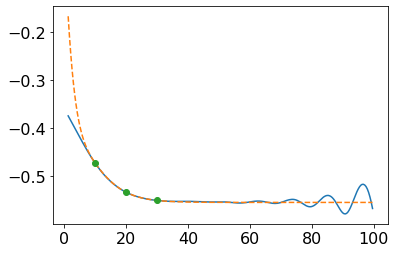

In [33]:
# mask = (x > -100) & (x < 10)
mask = (x > 1) & (x < 100)

plt.plot(x[mask], y[mask])
plt.plot(x[mask], cm.predict(x[mask]), ls='--')

plt.plot(collocation_points['0th'], rhs['0th'], 'o')


(-0.8, 0.0)

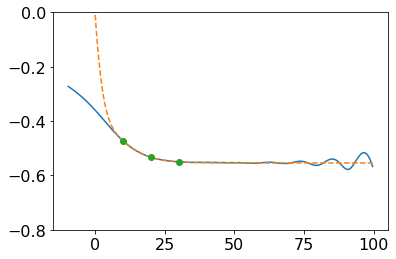

In [34]:
# mask = (x > -100) & (x < 10)
mask = (x > -10) & (x < 100)

plt.plot(x[mask], y[mask])
plt.plot(x[mask], cm.predict(x[mask]), ls='--')

# plt.plot(cm.collocation_points[0], cm.rhs[0], 'o')
plt.plot(collocation_points['0th'], rhs['0th'], 'o')
plt.ylim(-0.8,0)

# fitting:

## frequency merger and ringdown

## config

In [35]:
q = 18
assert q in q_to_idx_mapper.keys(), f'mass-ratio not available, pick from {list(q_to_idx_mapper.keys())}'

# target_data = 'amp'
target_data = 'freq'

idx = q_to_idx_mapper[q]

meta_data = data['meta_data'][idx]
wf_data = data['wf_data'][idx]

x = wf_data[:, col_mapper['time']]
y = wf_data[:, col_mapper[target_data]]

# y = 1-y/(-meta_data['fring']*2*np.pi)


iy = IUS(x, y) # interpolate so we can estimate derivatives



def merger_freq_config(wf_data, meta_data, iy):

    ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(7)])

    collocation_points = {
        # '0th':[-300, -200, -100, -12, 5],
        # '1st':[-300, 5],
        # '0th':[-300, -200, -100, -10, 10],
        # '1st':[-300, 10],
        '0th':[-300, -200, -100, -10, 0],
        '1st':[-300, 0],
    }

    rhs = {
        '0th':np.array(list(map(iy, collocation_points['0th']))),
        '1st':np.array(list(map(iy.derivative(), collocation_points['1st']))),
    }

    sub_dict = {
        'a_sym':meta_data['fdamp']*2*np.pi,
    }

    fit_meta_data = {
        # 'times': [-100, 10],
        'ansatz': ansatz,
        'collocation_points': collocation_points,
        'rhs': rhs,
        'sub_dict': sub_dict,
        'mask': (x >= -300) & (x <= 10),
    }
    return fit_meta_data



def ringdown_freq_config(wf_data, meta_data, iy):

    collocation_points = {
        # '0th':[-10, 10, 30],
        # '1st':[-10],
        '0th':[0, 10, 30],
        '1st':[0],
        # '2nd':[-10],
    }

    rhs = {
        '0th':np.array(list(map(iy, collocation_points['0th']))),
        '1st':np.array(list(map(iy.derivative(), collocation_points['1st']))),
        # '2nd':np.array(list(map(iy.derivative(2), collocation_points['2nd']))),
    }

    sub_dict = {
        'a_sym':meta_data['fdamp']*2*np.pi,
        'om_rd':-meta_data['fring']*2*np.pi,
    }

    # ringdown frequency
    # eq. 28 & 29 (arXiv:2012.11923)
    # om_bar = np.sum([sympy.tanh(a_sym * (x_sym))**power for power in range(4)])
    om_bar = np.sum([sympy.tanh(a_sym * (x_sym))**power for power in range(4)])
    # ansatz = om_rd * (1 - om_bar)
    # ansatz = sympy.expand(ansatz)
    ansatz = om_bar

    fit_meta_data = {
        # 'times': [10, 100],
        'ansatz': ansatz,
        'collocation_points': collocation_points,
        'rhs': rhs,
        'sub_dict': sub_dict,
        'mask': (x >= -20) & (x <= 100),
    }
    
    return fit_meta_data






In [36]:
merger_freq_fit_meta_data = merger_freq_config(wf_data, meta_data, iy)

In [37]:
ringdown_freq_fit_meta_data = ringdown_freq_config(wf_data, meta_data, iy)

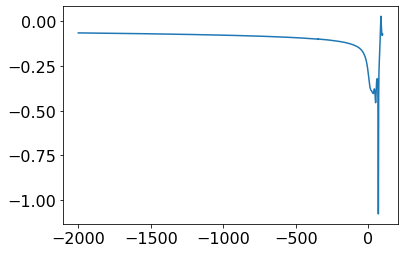

In [38]:
plt.plot(x, y)

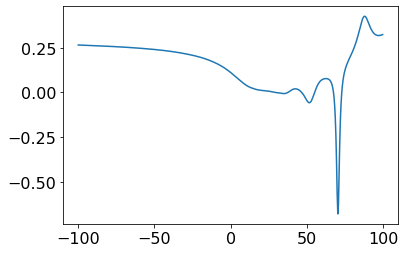

In [39]:
mask = (x > -100) & (x < 100)
plt.plot(x[mask], y[mask]-(-meta_data['fring']*2*np.pi))

In [40]:
cm_freq_merger = col.CollocationModel(
    collocation_points=[
        merger_freq_fit_meta_data['collocation_points']['0th'],
        merger_freq_fit_meta_data['collocation_points']['1st'],
    ],
    rhs=[
        merger_freq_fit_meta_data['rhs']['0th'],
        merger_freq_fit_meta_data['rhs']['1st'],
    ],
    ansatz=merger_freq_fit_meta_data['ansatz'],
    sub_dict=merger_freq_fit_meta_data['sub_dict'],
)

In [41]:
cm_freq_ringdown = col.CollocationModel(
    collocation_points=[
        ringdown_freq_fit_meta_data['collocation_points']['0th'],
        ringdown_freq_fit_meta_data['collocation_points']['1st'],
        # ringdown_freq_fit_meta_data['collocation_points']['2nd'],
    ],
    rhs=[
        ringdown_freq_fit_meta_data['rhs']['0th'],
        ringdown_freq_fit_meta_data['rhs']['1st'],
        # ringdown_freq_fit_meta_data['rhs']['2nd'],
    ],
    ansatz=ringdown_freq_fit_meta_data['ansatz'],
    sub_dict=ringdown_freq_fit_meta_data['sub_dict'],
)

In [42]:
cm_freq_merger.dof

7

In [43]:
cm_freq_ringdown.dof

4

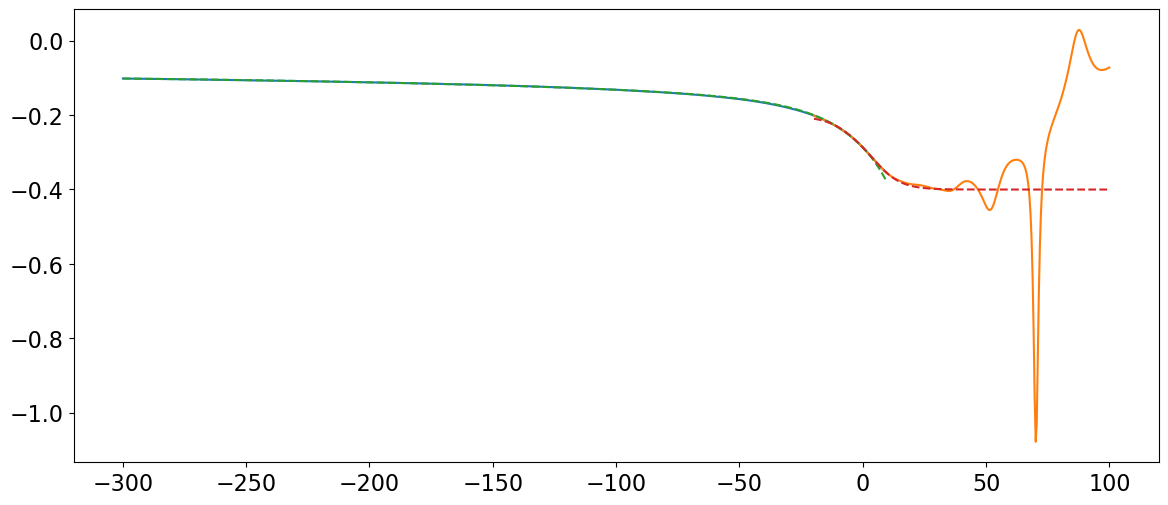

In [44]:
plt.figure(figsize=(14, 6), dpi=100)
# plt.plot(x, y)

plt.plot(x[merger_freq_fit_meta_data['mask']], y[merger_freq_fit_meta_data['mask']])
plt.plot(x[ringdown_freq_fit_meta_data['mask']], y[ringdown_freq_fit_meta_data['mask']])


plt.plot(x[merger_freq_fit_meta_data['mask']], cm_freq_merger.predict(x[merger_freq_fit_meta_data['mask']]), ls='--')
plt.plot(x[ringdown_freq_fit_meta_data['mask']], cm_freq_ringdown.predict(x[ringdown_freq_fit_meta_data['mask']]), ls='--')

# plt.ylim(-0.6, -0.05)
# plt.xlim(-100, 100)

(-100.0, 100.0)

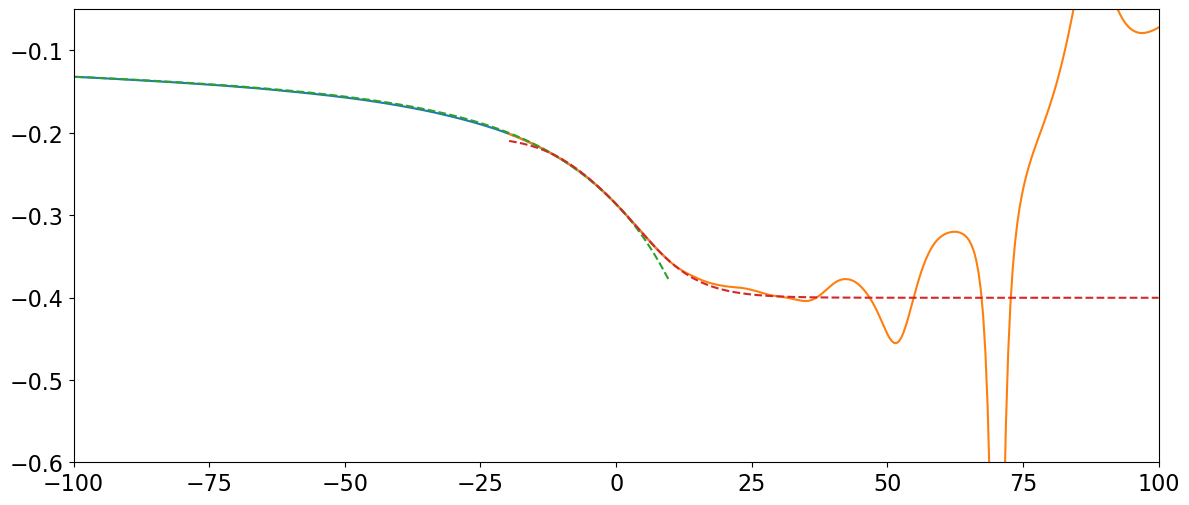

In [45]:
plt.figure(figsize=(14, 6), dpi=100)
# plt.plot(x, y)

plt.plot(x[merger_freq_fit_meta_data['mask']], y[merger_freq_fit_meta_data['mask']])
plt.plot(x[ringdown_freq_fit_meta_data['mask']], y[ringdown_freq_fit_meta_data['mask']])


plt.plot(x[merger_freq_fit_meta_data['mask']], cm_freq_merger.predict(x[merger_freq_fit_meta_data['mask']]), ls='--')
plt.plot(x[ringdown_freq_fit_meta_data['mask']], cm_freq_ringdown.predict(x[ringdown_freq_fit_meta_data['mask']]), ls='--')

plt.ylim(-0.6, -0.05)
plt.xlim(-100, 100)

# fitting:

## amplitude merger and ringdown

## config

In [46]:
q = 18
assert q in q_to_idx_mapper.keys(), f'mass-ratio not available, pick from {list(q_to_idx_mapper.keys())}'

target_data = 'amp'
# target_data = 'freq'

idx = q_to_idx_mapper[q]

meta_data = data['meta_data'][idx]
wf_data = data['wf_data'][idx]

x = wf_data[:, col_mapper['time']]
y = wf_data[:, col_mapper[target_data]]

iy = IUS(x, y) # interpolate so we can estimate derivatives



def merger_amp_config(wf_data, meta_data, iy):

    ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(6)])

    collocation_points = {
        '0th':[-300, -100, -12, 0],
        '1st':[-300, 0],
    }

    rhs = {
        '0th':np.array(list(map(iy, collocation_points['0th']))),
        '1st':np.array(list(map(iy.derivative(), collocation_points['1st']))),
    }

    sub_dict = {
        'a_sym':meta_data['fdamp']*2*np.pi,
    }

    fit_meta_data = {
        # 'times': [-100, 10],
        'ansatz': ansatz,
        'collocation_points': collocation_points,
        'rhs': rhs,
        'sub_dict': sub_dict,
        'mask': (x >= -300) & (x <= 10),
    }
    return fit_meta_data




def ringdown_amp_config(wf_data, meta_data, iy):

    
    collocation_points = {
        '0th':[0, 5, 20, 30],
        '1st':[0, 20, 30],
        # '2nd':[0]
    }

    rhs = {
        '0th':np.array(list(map(iy, collocation_points['0th']))),
        '1st':np.array(list(map(iy.derivative(), collocation_points['1st']))),
        # '2nd':np.array(list(map(iy.derivative(2), collocation_points['2nd']))),
    }

    sub_dict = {
        'a_sym':meta_data['fdamp']*2*np.pi,
    }

    ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(7)])

    fit_meta_data = {
        # 'times': [10, 100],
        'ansatz': ansatz,
        'collocation_points': collocation_points,
        'rhs': rhs,
        'sub_dict': sub_dict,
        'mask': (x >= 0) & (x <= 40),
    }
    
    return fit_meta_data






In [47]:
merger_amp_fit_meta_data = merger_amp_config(wf_data, meta_data, iy)

In [48]:
ringdown_amp_fit_meta_data = ringdown_amp_config(wf_data, meta_data, iy)

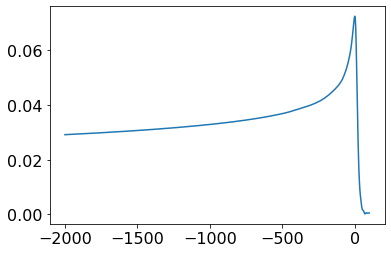

In [49]:
plt.plot(x, y)

In [50]:
cm_amp_merger = col.CollocationModel(
    collocation_points=[
        merger_amp_fit_meta_data['collocation_points']['0th'],
        merger_amp_fit_meta_data['collocation_points']['1st'],
    ],
    rhs=[
        merger_amp_fit_meta_data['rhs']['0th'],
        merger_amp_fit_meta_data['rhs']['1st'],
    ],
    ansatz=merger_amp_fit_meta_data['ansatz'],
    sub_dict=merger_amp_fit_meta_data['sub_dict'],
)

In [51]:
cm_amp_ringdown = col.CollocationModel(
    collocation_points=[
        ringdown_amp_fit_meta_data['collocation_points']['0th'],
        ringdown_amp_fit_meta_data['collocation_points']['1st'],
        # ringdown_amp_fit_meta_data['collocation_points']['2nd'],
    ],
    rhs=[
        ringdown_amp_fit_meta_data['rhs']['0th'],
        ringdown_amp_fit_meta_data['rhs']['1st'],
        # ringdown_amp_fit_meta_data['rhs']['2nd'],
    ],
    ansatz=ringdown_amp_fit_meta_data['ansatz'],
    sub_dict=ringdown_amp_fit_meta_data['sub_dict'],
)

In [52]:
cm_amp_ringdown.collocation_points_1d

array([ 0,  5, 20, 30,  0, 20, 30])

In [53]:
cm_amp_merger.dof

6

In [54]:
cm_amp_ringdown.dof

7

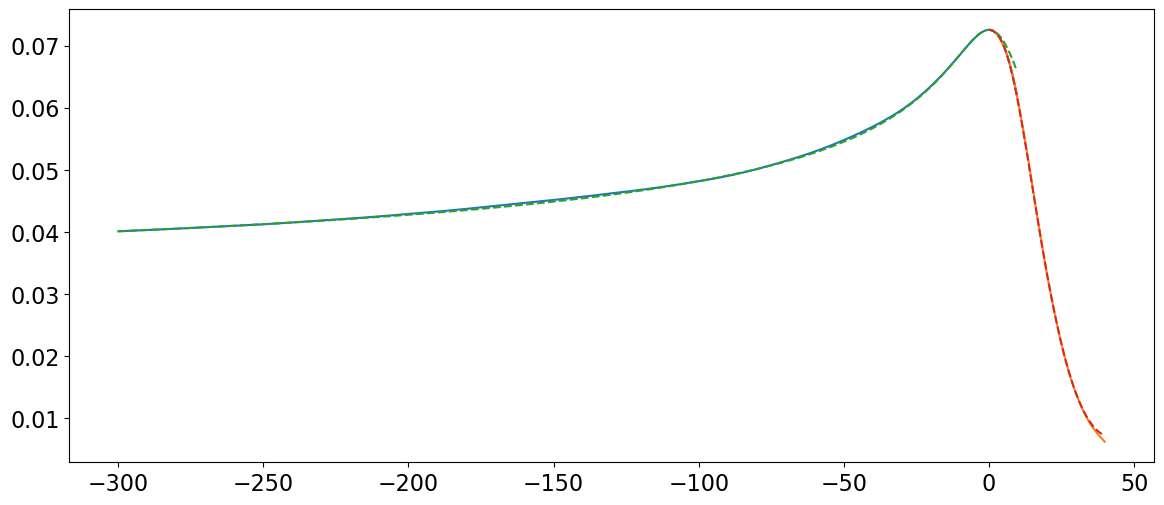

In [55]:
plt.figure(figsize=(14, 6), dpi=100)
# plt.plot(x, y)

plt.plot(x[merger_amp_fit_meta_data['mask']], y[merger_amp_fit_meta_data['mask']])
plt.plot(x[ringdown_amp_fit_meta_data['mask']], y[ringdown_amp_fit_meta_data['mask']])


plt.plot(x[merger_amp_fit_meta_data['mask']], cm_amp_merger.predict(x[merger_amp_fit_meta_data['mask']]), ls='--')
plt.plot(x[ringdown_amp_fit_meta_data['mask']], cm_amp_ringdown.predict(x[ringdown_amp_fit_meta_data['mask']]), ls='--')

# plt.ylim(0.001, 0.08)
# plt.xlim(-300, 50)
# plt.yscale('log')

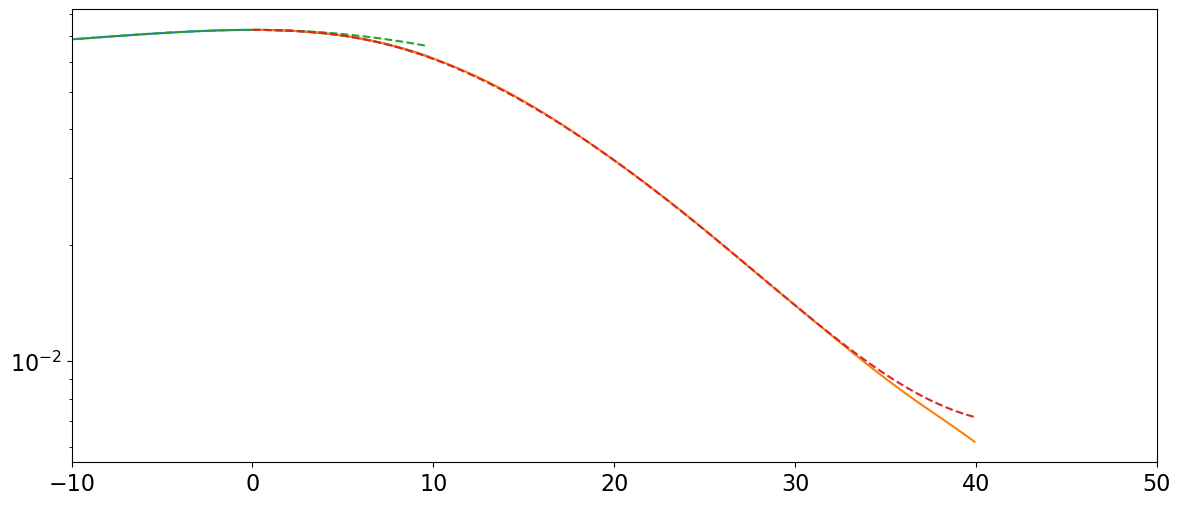

In [56]:
plt.figure(figsize=(14, 6), dpi=100)
# plt.plot(x, y)

plt.plot(x[merger_amp_fit_meta_data['mask']], y[merger_amp_fit_meta_data['mask']])
plt.plot(x[ringdown_amp_fit_meta_data['mask']], y[ringdown_amp_fit_meta_data['mask']])


plt.plot(x[merger_amp_fit_meta_data['mask']], cm_amp_merger.predict(x[merger_amp_fit_meta_data['mask']]), ls='--')
plt.plot(x[ringdown_amp_fit_meta_data['mask']], cm_amp_ringdown.predict(x[ringdown_amp_fit_meta_data['mask']]), ls='--')

# plt.ylim(0.001, 0.08)
plt.xlim(-10, 50)
plt.yscale('log')

# full waveform

In [57]:
def full_phase(t, freq):
    ifreq = IUS(t, freq)
    return ifreq.antiderivative()(t)

In [58]:
def full_freq(t, merger_model, early_ringdown_model, t_m_erd=0):
        y = np.zeros_like(t)
        
        mask = t < t_m_erd
        y[mask] = merger_model.predict(t[mask])
        
        mask = t >= t_m_erd
        y[mask] = early_ringdown_model.predict(t[mask])

        return y

In [59]:
def full_amp(t, merger_model, early_ringdown_model, fdamp, t_m_erd=0, t_erd_end=30):
        y = np.zeros_like(t)
        
        mask = t < t_m_erd
        y[mask] = merger_model.predict(t[mask])
        
        mask = (t >= t_m_erd) & (t < t_erd_end)
        y[mask] = early_ringdown_model.predict(t[mask])

        # this is the value of the final point
        # which we use to connect the exponential ringdown
        y0 = early_ringdown_model.predict(t_erd_end)
        
        mask = t > t_erd_end
        a, b = connect_rd(t0=t_erd_end, y0=y0, fdamp=fdamp)
        
        y[mask] = np.exp(rd_ansatz_log(t[mask], a, b))

        return y

In [60]:
# t = np.linspace(-500, 100, 1000)

# mask = x>-100
# mask = x>-200
mask = x>-300
t = x.copy()[mask]

In [61]:
yhat_amp = full_amp(t, cm_amp_merger, cm_amp_ringdown, meta_data['fdamp'])

In [62]:
yhat_freq = full_freq(t, cm_freq_merger, cm_freq_ringdown)

In [63]:
yhat_phase = full_phase(t, yhat_freq)
# iphase = IUS(t, yhat_phase)
# yhat_phase = yhat_phase - iphase(-500)

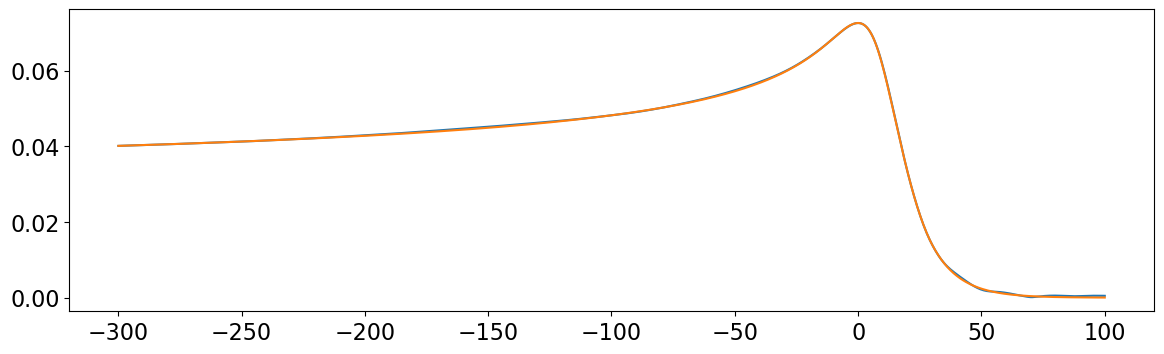

In [64]:
plt.figure(figsize=(14, 4), dpi=100)
plt.plot(x[mask], y[mask])
plt.plot(t, yhat_amp)
# plt.yscale('log')
# plt.xlim(2, 100)

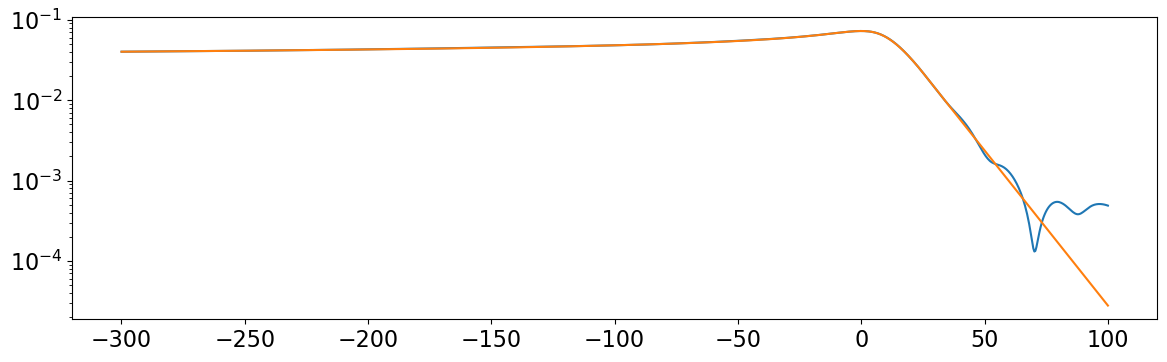

In [65]:
plt.figure(figsize=(14, 4), dpi=100)
plt.plot(x[mask], y[mask])
plt.plot(t, yhat_amp)
plt.yscale('log')
# plt.xlim(2, 100)

(-0.001, 0.001)

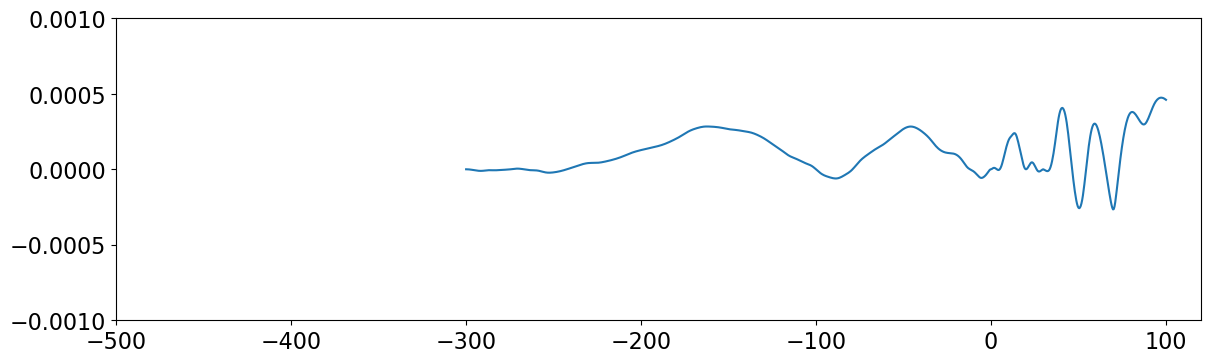

In [66]:
plt.figure(figsize=(14, 4), dpi=100)
plt.plot(x[mask], y[mask]-yhat_amp)
# plt.yscale('log')
plt.xlim(-500)
plt.ylim(-0.001,0.001)

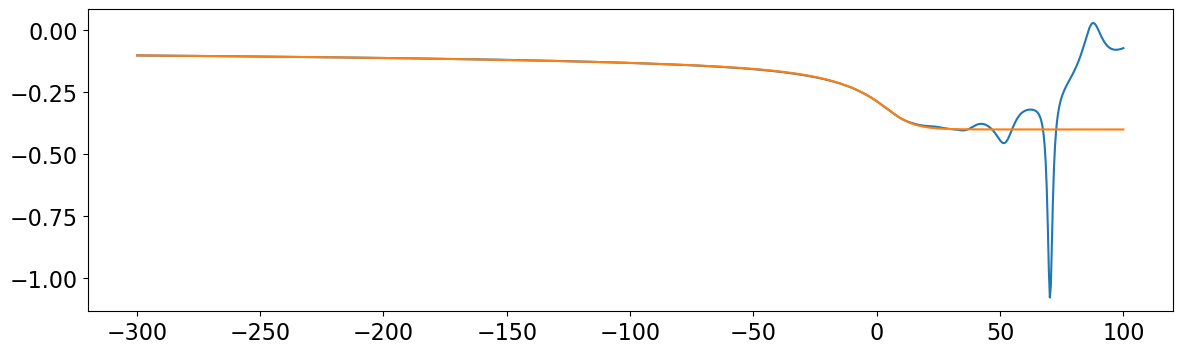

In [67]:
plt.figure(figsize=(14, 4), dpi=100)
plt.plot(x[mask], wf_data[mask,col_mapper['freq']])
plt.plot(t, yhat_freq)
# plt.yscale('log')
# plt.xlim(2, 100)

In [68]:
plt.figure(figsize=(14, 4), dpi=100)
plt.plot(x[mask], wf_data[mask,col_mapper['freq']]-yhat_freq)
# plt.yscale('log')
plt.xlim(-500)
plt.ylim(-0.01,0.01)

(-0.01, 0.01)

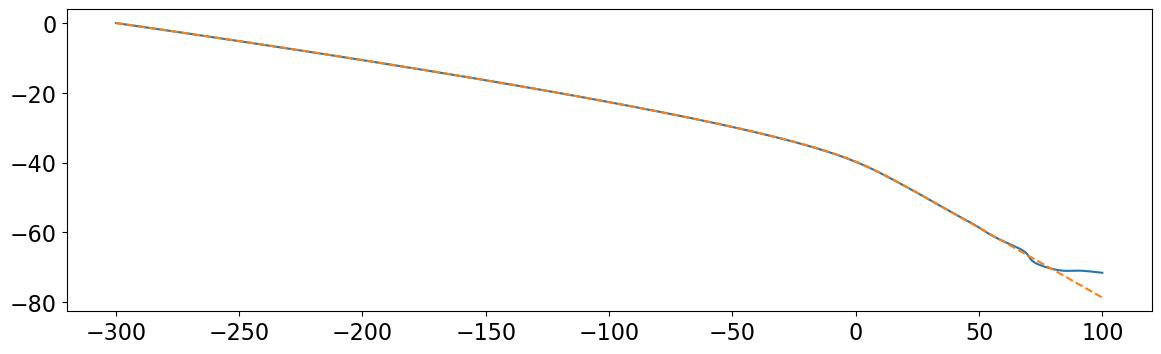

In [69]:
plt.figure(figsize=(14, 4), dpi=100)
plt.plot(x[mask], wf_data[mask,col_mapper['phase']]-wf_data[mask,col_mapper['phase']][0])
plt.plot(t, yhat_phase, ls='--')
# plt.yscale('log')

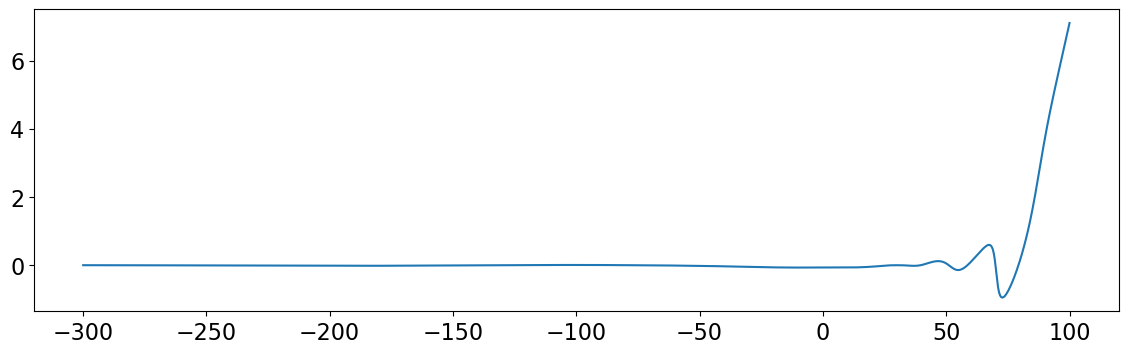

In [70]:
plt.figure(figsize=(14, 4), dpi=100)
plt.plot(x[mask], (wf_data[mask,col_mapper['phase']]-wf_data[mask,col_mapper['phase']][0])-yhat_phase)
# plt.yscale('log')

In [71]:
nr_phase_shift = wf_data[mask, col_mapper['phase']] - wf_data[mask, col_mapper['phase']][0]
h_nr = wf_data[mask, col_mapper['amp']] * np.exp(-1.j * nr_phase_shift)
full_h = yhat_amp * np.exp(-1.j * yhat_phase)

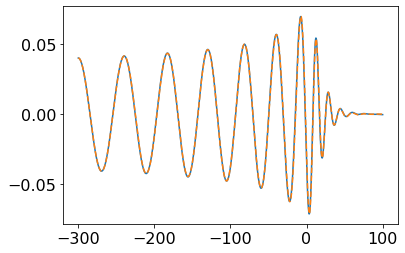

In [72]:
plt.plot(t, h_nr.real)
plt.plot(t, full_h.real, ls='--')
# plt.xlim(-500, 100)

In [73]:
def match(h1, h2, times):
        
    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df
    
    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)
    
    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm
    
    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)
    

    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    return ifft / h1h1 / h2h2 * 4 * dt

In [74]:
np.max(np.abs(match(h_nr, full_h, t)))

0.9996385038213744

# look at distribution of collocation point values across parameter space

In [75]:
merger_freq_fit_meta_data = {}
ringdown_freq_fit_meta_data = {}
merger_amp_fit_meta_data = {}
ringdown_amp_fit_meta_data = {}

for q in q_to_idx_mapper.keys():
    
    ####

    target_data = 'freq'

    idx = q_to_idx_mapper[q]

    meta_data = data['meta_data'][idx]
    wf_data = data['wf_data'][idx]

    x = wf_data[:, col_mapper['time']]
    y = wf_data[:, col_mapper[target_data]]

    iy = IUS(x, y) # interpolate so we can estimate derivatives
    
    merger_freq_fit_meta_data[q] = merger_freq_config(wf_data, meta_data, iy)
    ringdown_freq_fit_meta_data[q] = ringdown_freq_config(wf_data, meta_data, iy)
    
    ####
    
    target_data = 'amp'

    x = wf_data[:, col_mapper['time']]
    y = wf_data[:, col_mapper[target_data]]

    iy = IUS(x, y) # interpolate so we can estimate derivatives
    
    merger_amp_fit_meta_data[q] = merger_amp_config(wf_data, meta_data, iy)
    ringdown_amp_fit_meta_data[q] = ringdown_amp_config(wf_data, meta_data, iy)

In [76]:
merger_freq_fit_meta_data[1]['collocation_points']

{'0th': [-300, -200, -100, -10, 0], '1st': [-300, 0]}

In [77]:
ringdown_freq_fit_meta_data[1]['collocation_points']

{'0th': [0, 10, 30], '1st': [0]}

In [78]:
merger_amp_fit_meta_data[1]['collocation_points']

{'0th': [-300, -100, -12, 0], '1st': [-300, 0]}

In [79]:
ringdown_amp_fit_meta_data[1]['collocation_points']

{'0th': [0, 5, 20, 30], '1st': [0, 20, 30]}

In [80]:
merger_freq_fit_meta_data[1]['collocation_points']

{'0th': [-300, -200, -100, -10, 0], '1st': [-300, 0]}

In [81]:
merger_freq_fit_meta_data[1]['rhs']

{'0th': array([-0.08058661, -0.0928032 , -0.11918225, -0.2700535 , -0.35939773]),
 '1st': array([-9.27708448e-05, -1.11976339e-02])}

In [82]:
# setup up data to fit
# as a function of mass-ratio
# target = ['merger_freq', 'ringdown_freq', 'merger_amp', 'ringdown_amp']
# derivative = ['0th', '1st', '2nd']
# pdata: parameter space data
# pdata_cp[target][derivative][collocation point] # collocation points
# pdata_x = mass-ratios
# pdata_y[target][derivative] = rhs (for each mass-ratio)


pdata_x = np.array(list(q_to_idx_mapper.keys()))
# pdata_x = np.array(list(q_to_idx_mapper.keys())[:-1])
pdata_cp = {}
pdata_y = {}
pdata_sign = {} # keep track of the sign of the rhs. this is so we can take log(abs(rhs)) for modelling and undo this
target_mapper = {'merger_freq':merger_freq_fit_meta_data, 'ringdown_freq':ringdown_freq_fit_meta_data, 'merger_amp':merger_amp_fit_meta_data, 'ringdown_amp':ringdown_amp_fit_meta_data}

for k in target_mapper.keys():
    pdata_y[k] = {}
    pdata_cp[k] = {}
    pdata_sign[k] = {}
    derivatives = target_mapper[k][1]['collocation_points'].keys()
    for d in derivatives:
        pdata_y[k][d] = {}
        pdata_cp[k][d] = {}
        pdata_sign[k][d] = {}
        collocation_points = range(len(target_mapper[k][1]['collocation_points'][d]))
        for cp in collocation_points:
            pdata_y[k][d][cp] = [target_mapper[k][q]['rhs'][d][cp] for q in pdata_x]
            # pdata_y[k][d][cp] = [np.log(np.abs(target_mapper[k][q]['rhs'][d][cp])) for q in pdata_x]
            pdata_cp[k][d][cp] = target_mapper[k][q]['collocation_points'][d][cp]
            pdata_sign[k][d][cp] = [np.sign(target_mapper[k][q]['rhs'][d][cp]) for q in pdata_x][0]


In [83]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, RationalQuadratic, Matern

In [84]:
np.sign(5)

1

In [85]:
# gpr.kernel_

In [86]:
# mus.shape

In [87]:
# model the difference between values

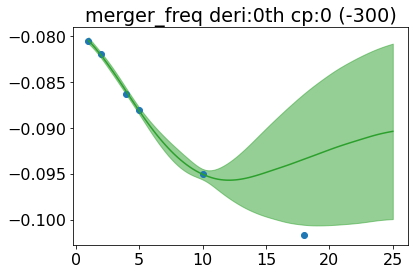

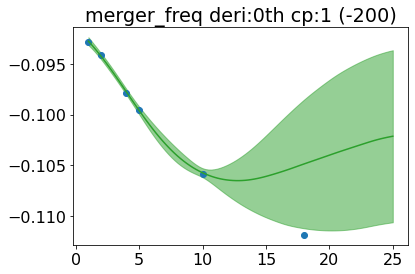

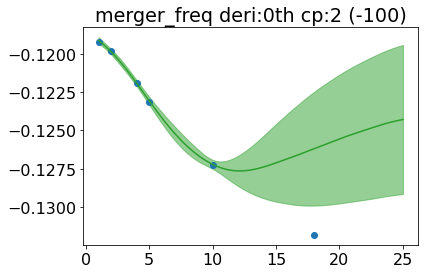

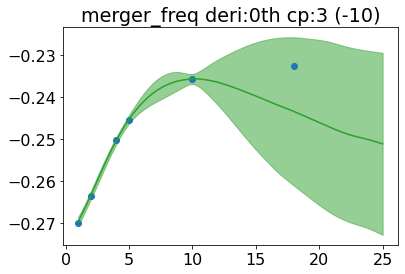

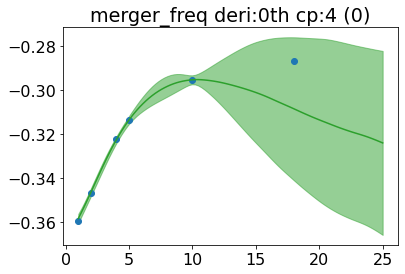

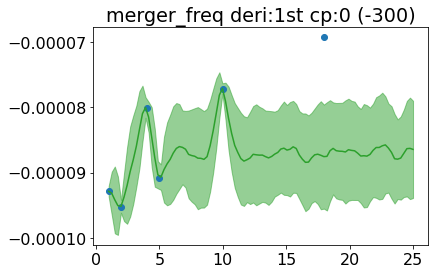

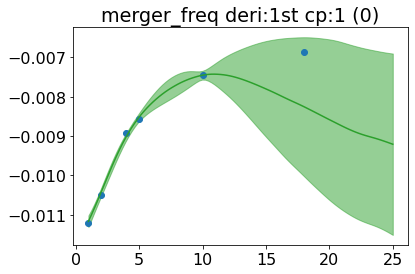

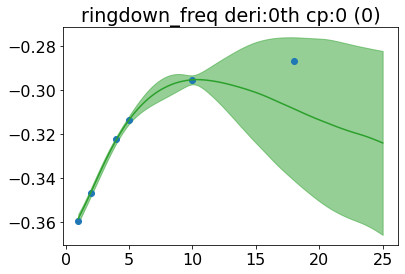

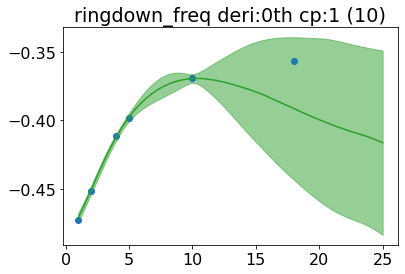

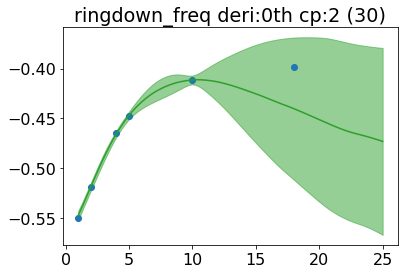

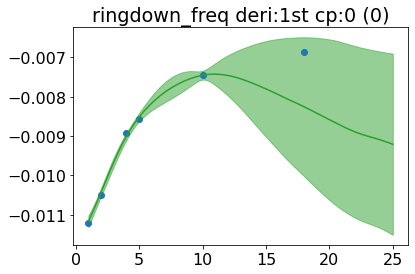

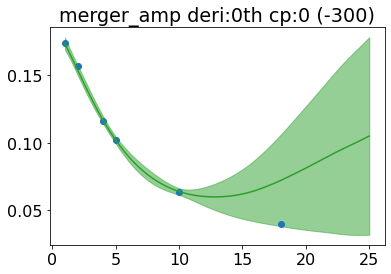

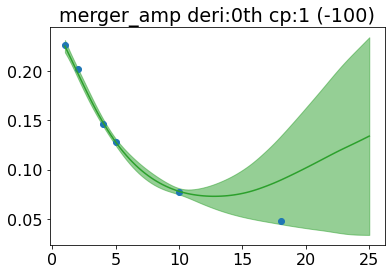

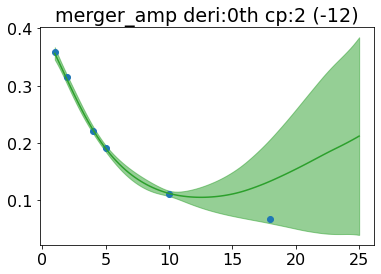

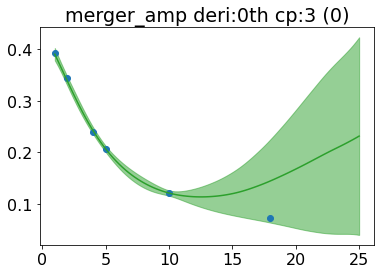

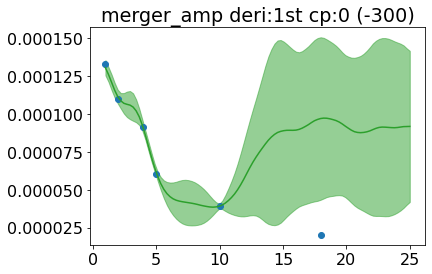

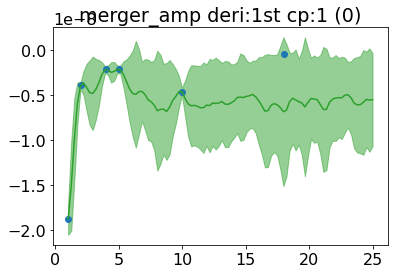

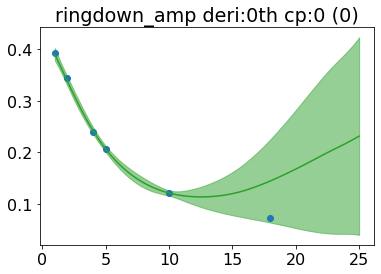

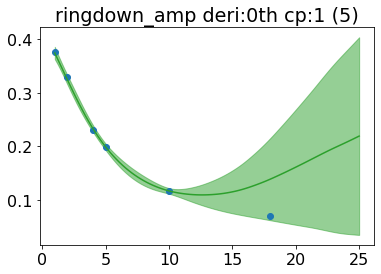

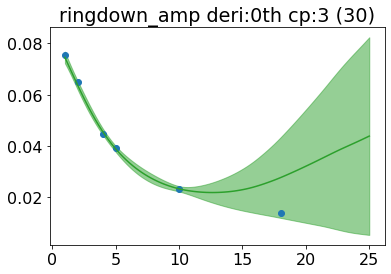

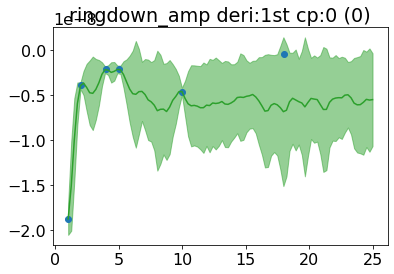

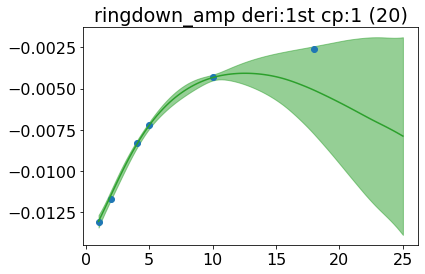

In [88]:
gprs = {}


q_fine = np.linspace(1, 25, 100)[:,np.newaxis]
for k in pdata_y.keys():
    gprs[k] = {}
    for d in pdata_y[k].keys():
        gprs[k][d] = {}
        for cp in pdata_y[k][d].keys():
            
            # alpha=1e-10
            # alpha=1e-5
            alpha=1e-2
            kernel = Matern(nu=2.5) * ConstantKernel()
            # kernel = RBF() #+ WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-18, 100000.0))
            # kernel = ConstantKernel() * RBF() + ConstantKernel() * RBF()  #+ ConstantKernel() * RBF()
            # kernel = ConstantKernel() * RationalQuadratic() + ConstantKernel() * RationalQuadratic()
            
            # remove last mass-ratio in fitting to test extrapolation
            x_to_fit = pdata_x[:,np.newaxis][:-1]
            y_to_fit = np.log(np.abs(pdata_y[k][d][cp]))[:-1]
            # y_to_fit = pdata_y[k][d][cp][:-1]
            gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=0, normalize_y=True, n_restarts_optimizer=5).fit(x_to_fit, y_to_fit)
            gprs[k][d][cp] = gpr
            
            
            mus = gpr.sample_y(q_fine, 100)
            mus = pdata_sign[k][d][cp] * np.exp(mus)
            # mus = mus
            mu = mus.mean(1)
            std = mus.std(1)
            
            # mu, std = gpr.predict(q_fine, return_std=True)
            
            plt.figure()
            plt.plot(pdata_x, pdata_y[k][d][cp], 'o')
            plt.plot(q_fine, mu, c='C2')
            plt.fill_between(q_fine[:,0], y1=mu-std, y2=mu+std, alpha=0.5, color='C2')
            
            title = f"{k} deri:{d} cp:{cp} ({pdata_cp[k][d][cp]})"
            plt.title(title)
            
            # plt.xlim(17,21)
            # plt.ylim(0, 0.07)
            
            plt.show()
            plt.close()

In [89]:
def get_rhs_gpr_prediction(gprs_dict, mass_ratio, pdata_sign, sample_or_mean='sample', random_state=0):
    mus = {}
    # derivatives
    for d in gprs_dict.keys():
        # collocation points
        # if sample_or_mean == 'mean':
        #     mus[d] = np.array([gprs_dict[d][cp].predict(np.array([mass_ratio])[:,np.newaxis]) for cp in gprs_dict[d].keys()])[:,-1]
        # elif sample_or_mean == 'sample':
        #     mus[d] = np.array([gprs_dict[d][cp].sample_y(np.array([mass_ratio])[:,np.newaxis], random_state=random_state)[0] for cp in gprs_dict[d].keys()])[:,-1]
        
        if sample_or_mean == 'mean':
            mus[d] = np.array([pdata_sign[d][cp] * np.exp(gprs_dict[d][cp].predict(np.array([mass_ratio])[:,np.newaxis])) for cp in gprs_dict[d].keys()])[:,-1]
        elif sample_or_mean == 'sample':
            mus[d] = np.array([pdata_sign[d][cp] * np.exp(gprs_dict[d][cp].sample_y(np.array([mass_ratio])[:,np.newaxis], random_state=random_state)[0]) for cp in gprs_dict[d].keys()])[:,-1]
            
    return mus

In [90]:
sample_or_mean='mean'
# sample_or_mean='sample'
merger_amp_mus = get_rhs_gpr_prediction(gprs['merger_amp'], 18, sample_or_mean=sample_or_mean, pdata_sign=pdata_sign['merger_amp'])
ringdown_amp_mus = get_rhs_gpr_prediction(gprs['ringdown_amp'], 18, sample_or_mean=sample_or_mean, pdata_sign=pdata_sign['ringdown_amp'])
merger_freq_mus = get_rhs_gpr_prediction(gprs['merger_freq'], 18, sample_or_mean=sample_or_mean, pdata_sign=pdata_sign['merger_freq'])
ringdown_freq_mus = get_rhs_gpr_prediction(gprs['ringdown_freq'], 18, sample_or_mean=sample_or_mean, pdata_sign=pdata_sign['ringdown_freq'])

In [91]:
merger_amp_mus

{'0th': array([0.06766438, 0.08289213, 0.12172536, 0.13112498]),
 '1st': array([ 7.80579204e-05, -4.28756412e-09])}

In [92]:
merger_amp_mus

{'0th': array([0.06766438, 0.08289213, 0.12172536, 0.13112498]),
 '1st': array([ 7.80579204e-05, -4.28756412e-09])}

## predict with gpr model

In [93]:
cm_amp_merger.collocation_points

[[-300, -100, -12, 0], [-300, 0]]

In [94]:
cm_amp_merger.rhs

[array([0.04009083, 0.04816363, 0.06743007, 0.07254813]),
 array([ 2.01797164e-05, -4.11880217e-10])]

In [95]:
gpr_cm_amp_merger = col.CollocationModel(
    collocation_points=[
        merger_amp_fit_meta_data[18]['collocation_points']['0th'],
        merger_amp_fit_meta_data[18]['collocation_points']['1st'],
    ],
    rhs=[
        merger_amp_mus['0th'],
        merger_amp_mus['1st'],
    ],
    ansatz=merger_amp_fit_meta_data[18]['ansatz'],
    sub_dict=merger_amp_fit_meta_data[18]['sub_dict'],
)

gpr_cm_amp_ringdown = col.CollocationModel(
    collocation_points=[
        ringdown_amp_fit_meta_data[18]['collocation_points']['0th'],
        ringdown_amp_fit_meta_data[18]['collocation_points']['1st'],
    ],
    rhs=[
        ringdown_amp_mus['0th'],
        ringdown_amp_mus['1st'],
    ],
    ansatz=ringdown_amp_fit_meta_data[18]['ansatz'],
    sub_dict=ringdown_amp_fit_meta_data[18]['sub_dict'],
)

In [96]:
gpr_cm_freq_merger = col.CollocationModel(
    collocation_points=[
        merger_freq_fit_meta_data[18]['collocation_points']['0th'],
        merger_freq_fit_meta_data[18]['collocation_points']['1st'],
    ],
    rhs=[
        merger_freq_mus['0th'],
        merger_freq_mus['1st'],
    ],
    ansatz=merger_freq_fit_meta_data[18]['ansatz'],
    sub_dict=merger_freq_fit_meta_data[18]['sub_dict'],
)

gpr_cm_freq_ringdown = col.CollocationModel(
    collocation_points=[
        ringdown_freq_fit_meta_data[18]['collocation_points']['0th'],
        ringdown_freq_fit_meta_data[18]['collocation_points']['1st'],
    ],
    rhs=[
        ringdown_freq_mus['0th'],
        ringdown_freq_mus['1st'],
    ],
    ansatz=ringdown_freq_fit_meta_data[18]['ansatz'],
    sub_dict=ringdown_freq_fit_meta_data[18]['sub_dict'],
)

(-300.0, 100.0)

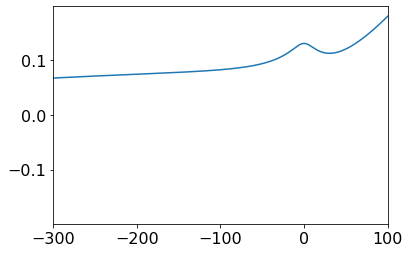

In [97]:
plt.plot(x, gpr_cm_amp_merger.predict(x))
plt.xlim(-300, 100)

In [98]:
# t = np.linspace(-500, 100, 1000)

# mask = x>-100
# mask = x>-200
mask = x>-300
t = x.copy()[mask]

In [99]:
yhat_amp = full_amp(t, gpr_cm_amp_merger, gpr_cm_amp_ringdown, meta_data['fdamp'])

In [100]:
yhat_freq = full_freq(t, gpr_cm_freq_merger, gpr_cm_freq_ringdown)

In [101]:
yhat_phase = full_phase(t, yhat_freq)
# iphase = IUS(t, yhat_phase)
# yhat_phase = yhat_phase - iphase(-500)

In [102]:
plt.figure(figsize=(14, 4), dpi=100)
plt.plot(x[mask], y[mask])
plt.plot(t, yhat_amp)
# plt.yscale('log')
# plt.xlim(2, 100)

In [103]:
nr_phase_shift = wf_data[mask, col_mapper['phase']] - wf_data[mask, col_mapper['phase']][0]
h_nr = wf_data[mask, col_mapper['amp']] * np.exp(-1.j * nr_phase_shift)
full_h = yhat_amp * np.exp(-1.j * yhat_phase)

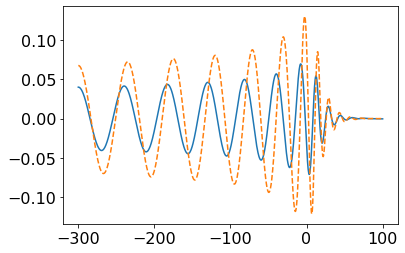

In [104]:
plt.plot(t, h_nr.real)
plt.plot(t, full_h.real, ls='--')
# plt.xlim(-500, 100)

In [105]:
np.max(np.abs(match(h_nr, full_h, t)))

0.9093686719939018

# loop over and sample

In [106]:
merger_amp_collocation_points_0th = merger_amp_fit_meta_data[1]['collocation_points']['0th']
merger_amp_collocation_points_1st = merger_amp_fit_meta_data[1]['collocation_points']['1st']

ringdown_amp_collocation_points_0th = ringdown_amp_fit_meta_data[1]['collocation_points']['0th']
ringdown_amp_collocation_points_1st = ringdown_amp_fit_meta_data[1]['collocation_points']['1st']

merger_freq_collocation_points_0th = merger_freq_fit_meta_data[1]['collocation_points']['0th']
merger_freq_collocation_points_1st = merger_freq_fit_meta_data[1]['collocation_points']['1st']

ringdown_freq_collocation_points_0th = ringdown_freq_fit_meta_data[1]['collocation_points']['0th']
ringdown_freq_collocation_points_1st = ringdown_freq_fit_meta_data[1]['collocation_points']['1st']



merger_amp_ansatz = merger_amp_fit_meta_data[1]['ansatz']
ringdown_amp_ansatz = ringdown_amp_fit_meta_data[1]['ansatz']
merger_freq_ansatz = merger_freq_fit_meta_data[1]['ansatz']
ringdown_freq_ansatz = ringdown_freq_fit_meta_data[1]['ansatz']

In [107]:
merger_amp_fit_meta_data[1]['sub_dict']

{'a_sym': 0.08542319294452659}

In [108]:
yhats_amp=[]
yhats_freq=[]
yhats_phase=[]
yhats_h=[]
n_samples=100
# n_samples=1

# sample_or_mean='mean'
sample_or_mean='sample'

# q=9
# q=20
q=18
# q=10
# q=12
# q=18.1
# q=7
# q=30
# q=15

eta = phenom.eta_from_q(q)
fin_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
fring = phenom.remnant.fring(eta, 0, 0, fin_spin)
fdamp = phenom.remnant.fdamp(eta, 0, 0, fin_spin)

sub_dict = {"a_sym":fdamp*2*np.pi}

idx = q_to_idx_mapper[q]

meta_data = data['meta_data'][idx]
wf_data = data['wf_data'][idx]

x = wf_data[:, col_mapper['time']]

mask = x>-300
t = x.copy()[mask]

nr_phase_shift = wf_data[mask, col_mapper['phase']] - wf_data[mask, col_mapper['phase']][0]
h_nr = wf_data[mask, col_mapper['amp']] * np.exp(-1.j * nr_phase_shift)






for n in range(n_samples):
    
    random_state=np.random.randint(1, 100000)
    merger_amp_mus = get_rhs_gpr_prediction(gprs['merger_amp'], q, sample_or_mean=sample_or_mean, random_state=random_state, pdata_sign=pdata_sign['merger_amp'])
    ringdown_amp_mus = get_rhs_gpr_prediction(gprs['ringdown_amp'], q, sample_or_mean=sample_or_mean, random_state=random_state, pdata_sign=pdata_sign['ringdown_amp'])
    merger_freq_mus = get_rhs_gpr_prediction(gprs['merger_freq'], q, sample_or_mean=sample_or_mean, random_state=random_state, pdata_sign=pdata_sign['merger_freq'])
    ringdown_freq_mus = get_rhs_gpr_prediction(gprs['ringdown_freq'], q, sample_or_mean=sample_or_mean, random_state=random_state, pdata_sign=pdata_sign['ringdown_freq'])
    
    # merger_amp_mus['0th'][-1] = ringdown_amp_mus['0th'][0]
    # merger_amp_mus['1st'][-1] = ringdown_amp_mus['1st'][0]
    # ringdown_amp_mus['0th'][0] = merger_amp_mus['0th'][-1]
    # ringdown_amp_mus['1st'][0] = merger_amp_mus['1st'][-1]
    
    
    gpr_cm_amp_merger = col.CollocationModel(
        collocation_points=[
            merger_amp_collocation_points_0th,
            merger_amp_collocation_points_1st,
        ],
        rhs=[
            merger_amp_mus['0th'],
            merger_amp_mus['1st'],
        ],
        ansatz=merger_amp_ansatz, #merger_amp_fit_meta_data[q]['ansatz'],
        sub_dict=sub_dict, #merger_amp_fit_meta_data[q]['sub_dict'],
    )

    gpr_cm_amp_ringdown = col.CollocationModel(
        collocation_points=[
            ringdown_amp_collocation_points_0th,
            ringdown_amp_collocation_points_1st,
        ],
        rhs=[
            ringdown_amp_mus['0th'],
            ringdown_amp_mus['1st'],
        ],
        ansatz=ringdown_amp_ansatz, #ringdown_amp_fit_meta_data[q]['ansatz'],
        sub_dict=sub_dict, #ringdown_amp_fit_meta_data[q]['sub_dict'],
    )
    
    gpr_cm_freq_merger = col.CollocationModel(
        collocation_points=[
            merger_freq_collocation_points_0th,
            merger_freq_collocation_points_1st,
        ],
        rhs=[
            merger_freq_mus['0th'],
            merger_freq_mus['1st'],
        ],
        ansatz=merger_freq_ansatz, #merger_freq_fit_meta_data[q]['ansatz'],
        sub_dict=sub_dict, #merger_freq_fit_meta_data[q]['sub_dict'],
    )

    gpr_cm_freq_ringdown = col.CollocationModel(
        collocation_points=[
            ringdown_freq_collocation_points_0th,
            ringdown_freq_collocation_points_1st,
        ],
        rhs=[
            ringdown_freq_mus['0th'],
            ringdown_freq_mus['1st'],
        ],
        ansatz=ringdown_freq_ansatz, #ringdown_freq_fit_meta_data[q]['ansatz'],
        sub_dict=sub_dict, #ringdown_freq_fit_meta_data[q]['sub_dict'],
    )
    
    
    # yhat_amp = full_amp(t, gpr_cm_amp_merger, gpr_cm_amp_ringdown, meta_data['fdamp'])
    yhat_amp = full_amp(t, gpr_cm_amp_merger, gpr_cm_amp_ringdown, fdamp)

    yhat_freq = full_freq(t, gpr_cm_freq_merger, gpr_cm_freq_ringdown)

    yhat_phase = full_phase(t, yhat_freq)

    full_h = yhat_amp * np.exp(-1.j * yhat_phase)
    
    yhats_amp.append(yhat_amp)
    yhats_freq.append(yhat_freq)
    yhats_phase.append(yhat_phase)
    yhats_h.append(full_h)

In [109]:
yhats_amp = np.array(yhats_amp)
yhats_freq = np.array(yhats_freq)
yhats_phase = np.array(yhats_phase)
yhats_h = np.array(yhats_h)

In [110]:
merger_amp_mus_test = get_rhs_gpr_prediction(gprs['merger_amp'], q, sample_or_mean=sample_or_mean, random_state=random_state, pdata_sign=pdata_sign['merger_amp'])

In [111]:
gprs['merger_amp']['0th']

{0: GaussianProcessRegressor(alpha=0.01,
                          kernel=Matern(length_scale=1, nu=2.5) * 1**2,
                          n_restarts_optimizer=5, normalize_y=True,
                          random_state=0),
 1: GaussianProcessRegressor(alpha=0.01,
                          kernel=Matern(length_scale=1, nu=2.5) * 1**2,
                          n_restarts_optimizer=5, normalize_y=True,
                          random_state=0),
 2: GaussianProcessRegressor(alpha=0.01,
                          kernel=Matern(length_scale=1, nu=2.5) * 1**2,
                          n_restarts_optimizer=5, normalize_y=True,
                          random_state=0),
 3: GaussianProcessRegressor(alpha=0.01,
                          kernel=Matern(length_scale=1, nu=2.5) * 1**2,
                          n_restarts_optimizer=5, normalize_y=True,
                          random_state=0)}

In [112]:
test_point = gprs['merger_amp']['0th'][0].sample_y(np.array([q])[:,np.newaxis], n_samples=1000)[0]

test_point_1 = gprs['merger_amp']['0th'][3].sample_y(np.array([q])[:,np.newaxis], n_samples=1000)[0]

In [113]:
test_point_1.std()

0.5174778249239985

In [114]:
test_point.min()

-4.0356730560808955

In [115]:
test_point.max()

-1.4771091931568634

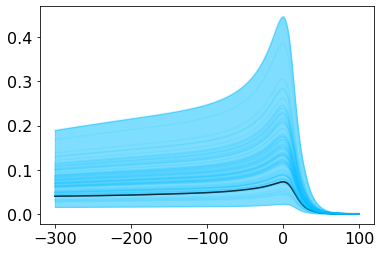

In [116]:
plt.plot(x[mask], wf_data[mask, col_mapper['amp']], c='k')
for n in range(n_samples):
    plt.plot(t, yhats_amp[n], color='deepskyblue', alpha=0.1)
plt.fill_between(t, y1=yhats_amp.min(0), y2=yhats_amp.max(0), alpha=0.5, color='deepskyblue')

# plt.errorbar([-300], [test_point.mean()], yerr=[[test_point.mean()-test_point.min()], [test_point.max()-test_point.mean()]])

# plt.errorbar([0], [test_point_1.mean()], yerr=[[test_point_1.mean()-test_point_1.min()], [test_point_1.max()-test_point_1.mean()]])

# plt.xlim(-310, -290)

# plt.xlim(-10, 30)

(-10.0, 30.0)

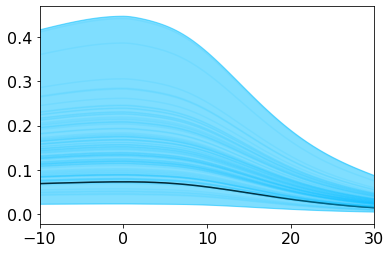

In [117]:
plt.plot(x[mask], wf_data[mask, col_mapper['amp']], c='k')
for n in range(n_samples):
    plt.plot(t, yhats_amp[n], color='deepskyblue', alpha=0.1)
plt.fill_between(t, y1=yhats_amp.min(0), y2=yhats_amp.max(0), alpha=0.5, color='deepskyblue')
plt.xlim(-10, 30)

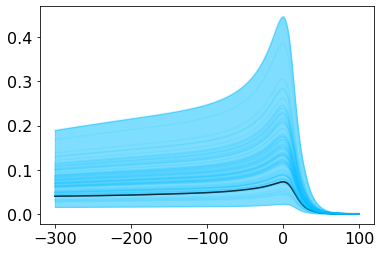

In [118]:
plt.plot(x[mask], wf_data[mask, col_mapper['amp']], c='k')
for n in range(n_samples):
    plt.plot(t, yhats_amp[n], color='deepskyblue', alpha=0.1)
plt.fill_between(t, y1=yhats_amp.min(0), y2=yhats_amp.max(0), alpha=0.5, color='deepskyblue')
# plt.xlim(-10, 10)

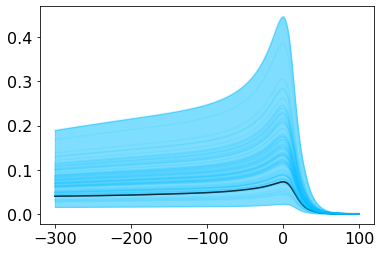

In [119]:
plt.plot(x[mask], wf_data[mask, col_mapper['amp']], c='k')
for n in range(n_samples):
    plt.plot(t, yhats_amp[n], color='deepskyblue', alpha=0.1)
plt.fill_between(t, y1=yhats_amp.min(0), y2=yhats_amp.max(0), alpha=0.5, color='deepskyblue')
# plt.xlim(-10, 10)

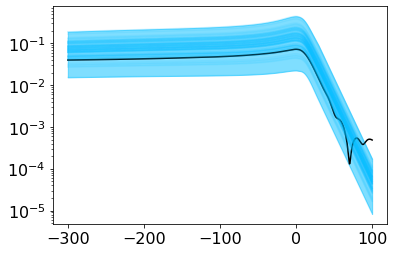

In [120]:
plt.plot(x[mask], wf_data[mask, col_mapper['amp']], c='k')
for n in range(n_samples):
    plt.plot(t, yhats_amp[n], color='deepskyblue', alpha=0.1)
plt.fill_between(t, y1=yhats_amp.min(0), y2=yhats_amp.max(0), alpha=0.5, color='deepskyblue')
# plt.xlim(-10, 10)
plt.yscale('log')

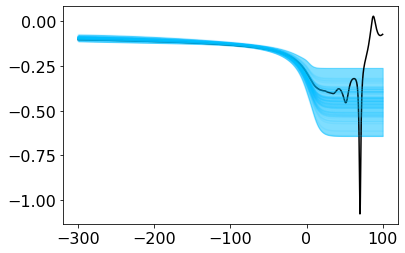

In [121]:
plt.plot(x[mask], wf_data[mask, col_mapper['freq']], c='k')
for n in range(n_samples):
    plt.plot(t, yhats_freq[n], color='deepskyblue', alpha=0.1)
plt.fill_between(t, y1=yhats_freq.min(0), y2=yhats_freq.max(0), alpha=0.5, color='deepskyblue')
# plt.xlim(-10, 10)

In [122]:
# note that we actually have a much better idea
# (smaller error bars) on
# the ringdown frequency and damping time.
# this can be folded into the model and probably
# reduce the uncertainty so that waveform samples
# don't have such a wide uncertainty during the ringdown

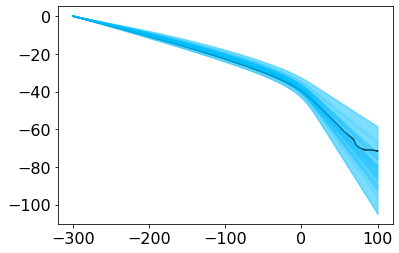

In [123]:
plt.plot(x[mask], nr_phase_shift, c='k')
for n in range(n_samples):
    plt.plot(t, yhats_phase[n], color='deepskyblue', alpha=0.1)
plt.fill_between(t, y1=yhats_phase.min(0), y2=yhats_phase.max(0), alpha=0.5, color='deepskyblue')
# plt.xlim(-10, 10)

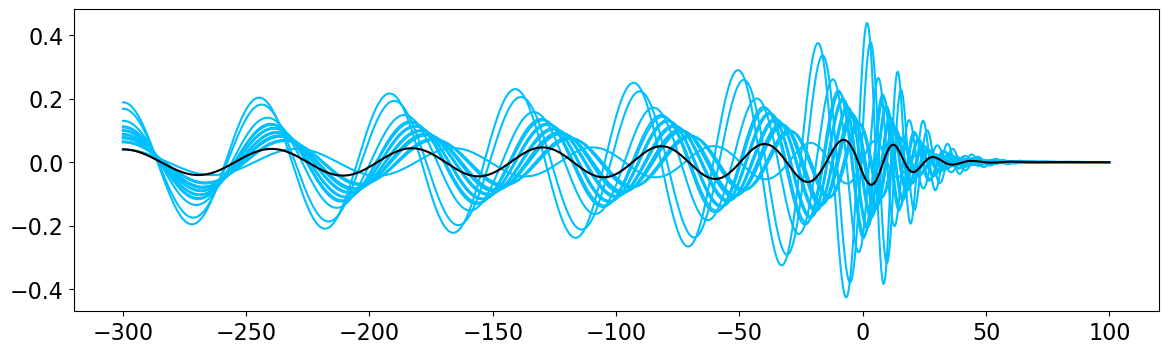

In [124]:
plt.figure(figsize=(14, 4), dpi=100)
for n in range(n_samples)[::5]:
    plt.plot(t, yhats_h[n].real, color='deepskyblue', ls='-')
# plt.fill_between(t, y1=yhats_h.real.min(0), y2=yhats_h.real.max(0), alpha=0.5, color='deepskyblue')
plt.plot(x[mask], h_nr.real, c='k')
# plt.xlim(-200, 100)

In [125]:
# use waveforms up to q=8
# to test

(-0.1, 0.1)

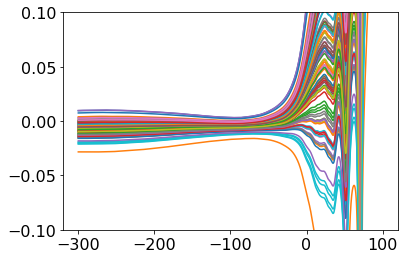

In [126]:
# residual freq with nr
for n in range(n_samples):
    plt.plot(t, wf_data[mask, col_mapper['freq']]-yhats_freq[n])
# plt.xlim(-10, 10)
plt.ylim(-0.1, 0.1)

In [127]:
all_matches = []
for n in range(n_samples):
    all_matches.append(np.max(np.abs(match(h_nr, yhats_h[n], t))))
all_matches = np.array(all_matches)

In [128]:
all_matches

array([0.8901161 , 0.58681598, 0.86210767, 0.87613979, 0.9576078 ,
       0.94849251, 0.80277964, 0.94101697, 0.91286351, 0.81284764,
       0.96166159, 0.95961887, 0.92565402, 0.88263669, 0.91209323,
       0.89794991, 0.96508338, 0.91220759, 0.9001841 , 0.69483118,
       0.96621036, 0.78484854, 0.85158049, 0.89057304, 0.79108419,
       0.89576282, 0.91268557, 0.78752715, 0.82967606, 0.71085071,
       0.9007411 , 0.90743335, 0.96308438, 0.94957185, 0.9330894 ,
       0.92807468, 0.91582268, 0.95326775, 0.8341913 , 0.71902299,
       0.96211856, 0.96626806, 0.833156  , 0.80695442, 0.92884191,
       0.96343952, 0.91951883, 0.96584316, 0.94404165, 0.80411311,
       0.77904757, 0.91597403, 0.88575621, 0.89272377, 0.81068157,
       0.93250895, 0.83207574, 0.8342833 , 0.96355191, 0.89226947,
       0.93155749, 0.82768295, 0.95099337, 0.94497815, 0.73727494,
       0.93415972, 0.94880342, 0.9661663 , 0.94475788, 0.96406527,
       0.91526986, 0.91833294, 0.96560188, 0.81012412, 0.91307

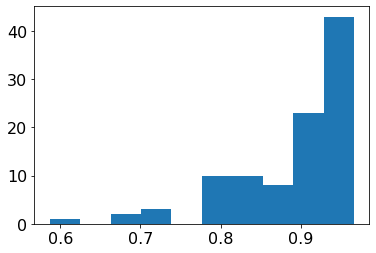

In [129]:
plt.hist(all_matches);

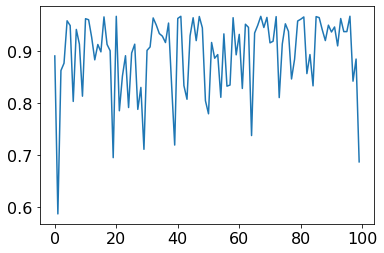

In [130]:
plt.plot(all_matches)